# アンサンブル学習

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, SGDRegressor
from sklearn.linear_model import PassiveAggressiveRegressor, ARDRegression, RidgeCV
from sklearn.linear_model import TheilSenRegressor, RANSACRegressor, HuberRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR, LinearSVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, ExtraTreesRegressor, HistGradientBoostingRegressor
from sklearn.ensemble import BaggingRegressor, GradientBoostingRegressor, VotingRegressor, StackingRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.cross_decomposition import PLSRegression

C:\Users\ryoga_inaba\.pyenv\pyenv-win\versions\3.10.5\lib\site-packages\sklearn\experimental\enable_hist_gradient_boosting.py:16: UserWarning: Since version 1.0, it is not needed to import enable_hist_gradient_boosting anymore. HistGradientBoostingClassifier and HistGradientBoostingRegressor are now stable and can be normally imported from sklearn.ensemble.
  warnings.warn(


In [3]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

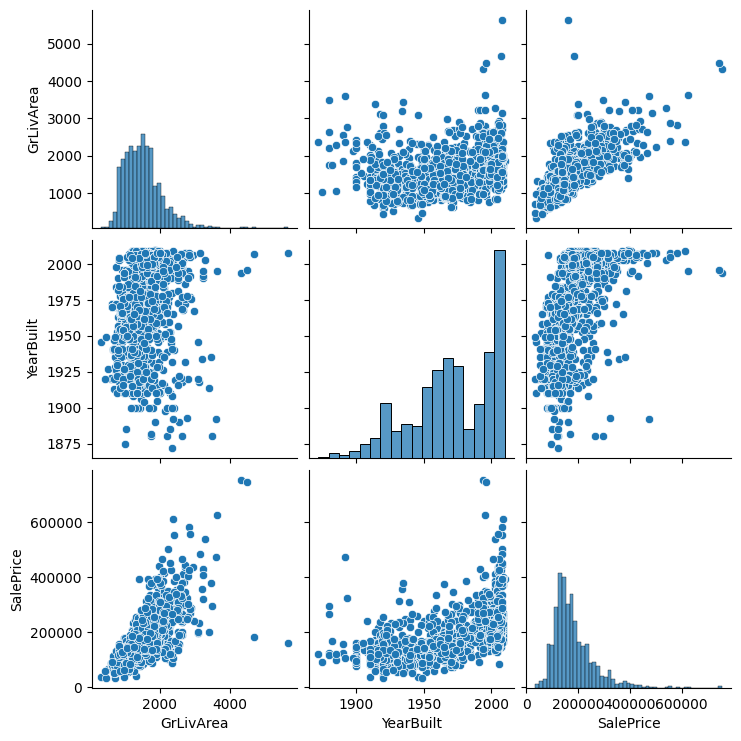

In [4]:
# データ読み込み
data = pd.read_csv('train.csv')
mini_data = data[['GrLivArea', 'YearBuilt', 'SalePrice']]
sns.pairplot(mini_data);

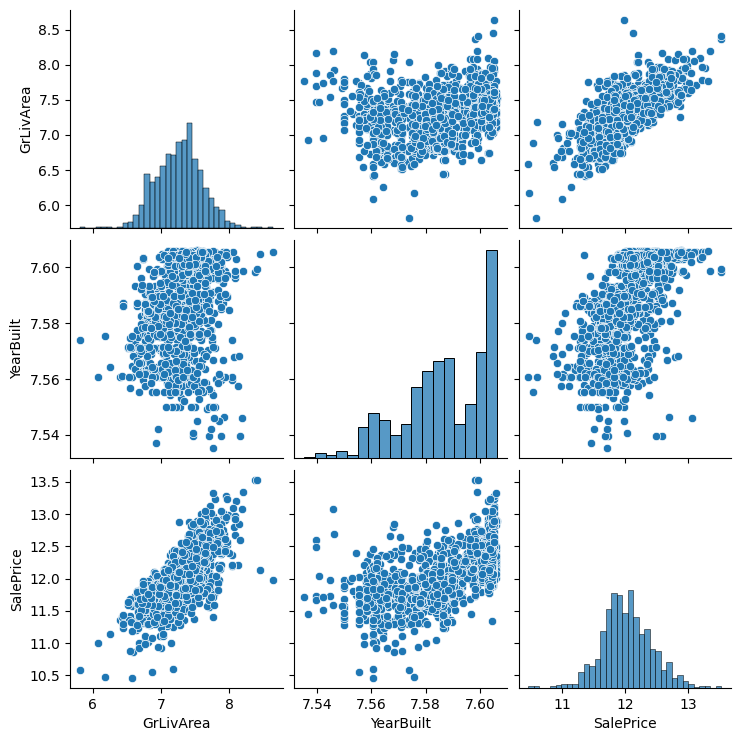

In [5]:
# 対数変換
log_mini_data = mini_data.apply(np.log1p)
sns.pairplot(log_mini_data);

In [6]:
from sklearn.model_selection import train_test_split

X = log_mini_data[['GrLivArea','YearBuilt']].values
y = log_mini_data['SalePrice'].values

X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.8, random_state=1000)

X_train.shape, X_valid.shape, y_train.shape, y_valid.shape

((1168, 2), (292, 2), (1168,), (292,))

## 【問題1】ブレンディングのスクラッチ実装

In [7]:
def blending(model_list):
    pred_list = []
    mse_list = []

    # 各モデルで学習、MSEを計算
    for model in model_list:
        model.fit(X_train, y_train)
        pred = model.predict(X_valid)
        pred_list.append(pred)
        mse_list.append(mean_squared_error(y_valid, pred))

    # ブレンディング
    pred_blend = np.mean(pred_list, axis=0)
    mse_blend = mean_squared_error(y_valid, pred_blend)

    for model, mse in zip(model_list, mse_list):
        print(f'MSE: {mse:.4f}  MODEL: {model}')

    print(f'\nMSE: {mse_blend:.4f}  MODEL: Blending')

#### ブレンディング１

In [8]:
model_list = [
    LinearRegression(),
    SVR(),
    DecisionTreeRegressor()
]
blending(model_list)

MSE: 0.0407  MODEL: LinearRegression()
MSE: 0.0433  MODEL: SVR()
MSE: 0.0629  MODEL: DecisionTreeRegressor()

MSE: 0.0377  MODEL: Blending


#### ブレンディング２

In [9]:
model_list = [
    GaussianProcessRegressor(),
    KNeighborsRegressor(),
    MLPRegressor(),
]
blending(model_list)

MSE: 0.0574  MODEL: GaussianProcessRegressor()
MSE: 0.0449  MODEL: KNeighborsRegressor()
MSE: 0.0686  MODEL: MLPRegressor()

MSE: 0.0419  MODEL: Blending


#### ブレンディング３

In [10]:
params = [100, 200, 300]
model_list = [DecisionTreeRegressor(random_state=i) for i in params]
blending(model_list)

MSE: 0.0656  MODEL: DecisionTreeRegressor(random_state=100)
MSE: 0.0653  MODEL: DecisionTreeRegressor(random_state=200)
MSE: 0.0659  MODEL: DecisionTreeRegressor(random_state=300)

MSE: 0.0648  MODEL: Blending


## 【問題2】バギングのスクラッチ実装

In [11]:
n = 20
models = []

for i in range(n):
    X_bagging, X_, y_bagging, y_ = train_test_split(X_train, y_train, train_size=0.2, shuffle=True)
    
    model = DecisionTreeRegressor()
    model.fit(X_bagging, y_bagging)
    models.append(model)

y_pred = np.zeros(len(X_valid))
mse_list = []

for regr in models:
    pred = regr.predict(X_valid)
    y_pred += pred
    mse_list.append(mean_squared_error(y_valid, pred))
    
y_pred /= n
mse_bagging = mean_squared_error(y_valid, y_pred)

print('--- MSE ---')
for i, mse in enumerate(mse_list):
    print(f'Decision Tree {i+1:<2} : {mse:.4f}')
print('\nBagging : {:.4f}'.format(mse_bagging))

--- MSE ---
Decision Tree 1  : 0.0926
Decision Tree 2  : 0.0777
Decision Tree 3  : 0.0840
Decision Tree 4  : 0.0677
Decision Tree 5  : 0.0813
Decision Tree 6  : 0.0839
Decision Tree 7  : 0.0727
Decision Tree 8  : 0.0646
Decision Tree 9  : 0.0633
Decision Tree 10 : 0.0889
Decision Tree 11 : 0.1008
Decision Tree 12 : 0.0886
Decision Tree 13 : 0.0726
Decision Tree 14 : 0.0657
Decision Tree 15 : 0.0841
Decision Tree 16 : 0.0842
Decision Tree 17 : 0.0844
Decision Tree 18 : 0.0841
Decision Tree 19 : 0.0811
Decision Tree 20 : 0.0880

Bagging : 0.0394


## 【問題3】スタッキングのスクラッチ実装

In [12]:
class Stacking():
    """
    スタッキングのClass
    Parameters
    ----------
    max_depth : int
      スタッキング可能な最大学習深度
    splits : int
      ブレンドデータ作成時のデータ分割数（CV分割数）
    models : dictionary
      学習モデル {key:n_depth, values:model} を渡す
    fit_models : list
      保存する学習済みモデルのリスト
    """
    def __init__(self, max_depth, splits, models):
        self.max_depth = max_depth
        self.n_splits = splits
        self.models = models
        self.fit_models = []
        
    def blending(self, X, y, m):
        """
        ブレンドデータ作成機能
        Parameters
        ----------
        X : 次の形の ndarray、形状 (n_samples、n_features)
            訓練データの特徴
        y : 次の形の ndarray, shape (n_samples,)
            学習データのラベル値
        m : class
            トレーニングモデルのインスタンス
        """
        self.y_blend = np.zeros(len(X))
        
        kf = KFold(n_splits=self.n_splits, shuffle=False)
        
        # CV
        for train_index, valid_index in kf.split(X):
            X_train, X_valid = X[train_index], X[valid_index]
            y_train, y_valid = y[train_index], y[valid_index]
            
            y_train = y_train.ravel()
            y_valid = y_valid.ravel()
            
            # トレーニングデータによるトレーニングモデル作成
            regr = m
            regr.fit(X_train, y_train)
            self.fit_models.append(regr)
            
            # ブレンドデータ作成
            self.y_blend[valid_index] = regr.predict(X_valid)
            
            # 問題用
            y_pred = regr.predict(X_valid)
            mse = mean_squared_error(y_valid, y_pred)
            print(f'{regr} : {mse:.4f}')
    
    def fit_(self, X, y, depth):
        """
        この深さでブレンドデータを作成する
        Parameters
        ----------
        X : 次の形の ndarray、形状 (n_samples、n_features)
            訓練データの特徴
        y : 次の形の ndarray, shape (n_samples,)
            学習データのラベル値
        depth : int
            このステージの深さ
        """
        self.depth = depth
        
        # 最終学習モデル
        if self.depth == self.max_depth:
            self.model = self.models[self.depth]
            self.model.fit(X, y)
            return
        
        # この深さのトレーニングモデルを用意する
        models = self.models[self.depth]
        self.y_blending = np.zeros([len(X),len(models)])
        
        # この深さのトレーニングモデルでブレンドデータを作る
        # cvの空いている部分に入れている
        for i, mdl in enumerate(models):
            self.blending(X, y, mdl)
            self.y_blending[:,i] = self.y_blend
        # 次のステージのためのX(blend_y)
        blend_y = self.y_blending
        
        # 再帰的
        self.bld = Stacking(self.max_depth, self.n_splits, self.models)
        self.bld.fit_(blend_y, y, depth+1)
        
    def predict_(self, X):
        if self.depth == self.max_depth:
            y_pred = self.model.predict(X)
            return y_pred
            
        else:
            tmp = 0
            self.y_pred = np.zeros(len(X))
            self.y_next = np.zeros([len(X), len(self.models[self.depth])])
            
            for mdl in self.fit_models:
                tmp += 1
                self.y_pred += mdl.predict(X)
                
                if tmp % self.n_splits == 0:
                    self.y_pred = self.y_pred / self.n_splits
                    self.y_next[:, int(tmp/self.n_splits) - 1] = self.y_pred
                    self.y_pred = np.zeros(len(X))
                    
            y_pred = self.bld.predict_(self.y_next)
            
        return y_pred

In [13]:
X_train.shape, X_valid.shape, y_train.shape, y_valid.shape

((1168, 2), (292, 2), (1168,), (292,))

In [14]:
models = {
    0: [LinearRegression(), SVR(), RandomForestRegressor()],
    1: LinearRegression()
}

print('--- MSE ---')

stk = Stacking(max_depth=1, splits=5, models=models)
stk.fit_(X_train, y_train, 0)
y_pred = stk.predict_(X_valid)

# 評価
mse = mean_squared_error(y_valid, y_pred)
print(f'\nStacking : {mse:.4f}')

--- MSE ---
LinearRegression() : 0.0499
LinearRegression() : 0.0489
LinearRegression() : 0.0458
LinearRegression() : 0.0450
LinearRegression() : 0.0458
SVR() : 0.0543
SVR() : 0.0448
SVR() : 0.0448
SVR() : 0.0503
SVR() : 0.0495
RandomForestRegressor() : 0.0558
RandomForestRegressor() : 0.0456
RandomForestRegressor() : 0.0480
RandomForestRegressor() : 0.0464
RandomForestRegressor() : 0.0484

Stacking : 0.0375
